In [1]:
import os

os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
from pathlib import Path
root_path = Path.cwd().parent.absolute()
import sys
sys.path.append(str(root_path))
import os

In [2]:

from flax import nnx
import jax
from jax._src.tree_util import tree_structure
import jax.numpy as jnp
from jaxtyping import Array

In [3]:
jax.devices()

[CudaDevice(id=0)]

In [4]:
from architectures.node import NeuralODE
from architectures.utils_node import eval_model
from architectures.architectures import MLP,ResNet
from geometry.G_matrix import G_matrix
from functionals.functions import create_potentials
from functionals.linear_funcitonal_class import LinearPotential
from functionals.internal_functional_class import InternalPotential
from functionals.functional import Potential
from flows.gradient_flow import run_gradient_flow
from flows.visualization import visualize_gradient_flow_results
from parametric_model.parametric_model import ParametricModel


In [5]:
jax.devices()
device = 0

In [6]:
# Create potentials
potentials = create_potentials()

In [13]:
gradient_flow_model = ParametricModel(
    parametric_map="node",
    architecture=[2, 1, 128],
    time_dependent=True,
    solver="euler",
    dt0=0.1,
    rhs_model="mlp"
)

In [14]:
# Gradient flow parameters
h = 1e-3 # Time step size
max_iterations = 250
tolerance = 1e-8
n_samples = 2_000  # Monte Carlo sample size


key = jax.random.PRNGKey(1234)
rngs = nnx.Rngs(key)

################## Create NODE model
# If the node is time dependent do d +1 for din
# model = MLP(din=2, num_layers=1, width_layers=128, dout=2, 
#                          activation_fn="tanh", rngs=rngs)
# gradient_flow_model = NeuralODE(
#     dynamics_model=model,
#     solver = 'euler',
#     time_dependent=True,
#     dt0=0.05,
# )
#################### ResNet model
# model = ResNet(din=2,num_layers=2,width_layers=32,dout=2,activation_fn='tanh',rngs=rngs)
# gradient_flow_model = parametric_model(model=model)

# Set parameters to be very small (near zero)
_, initial_params = nnx.split(gradient_flow_model)
scale_factor = 1e-2  # Small scaling to keep near identity

# Scale all parameters to be small
small_params = jax.tree.map(lambda p: p * scale_factor, initial_params)

# Merge back into the node
graphdef, _ = nnx.split(gradient_flow_model)
gradient_flow_model = nnx.merge(graphdef, small_params)

# Generate reference samples from λ = N(0, I)
key, subkey = jax.random.split(key)
z_samples = jax.random.normal(subkey, (n_samples, 2))

G_mat_flow = G_matrix(gradient_flow_model)
# Options: quadratic, double_well, strong_double_well,quartic,four_well,strong_four_well

solver= 'cg'


In [15]:
from functionals.functions import double_well_potential_fn,styblinski_tang_potential_fn
linear_potential = LinearPotential(potential_fn= styblinski_tang_potential_fn, coeff = 2.0)
internal_potential = InternalPotential(functional='entropy', coeff = 1.0, method= 'hutchinson',prob_dim=2)

potential = Potential(linear = linear_potential,
                      internal = internal_potential,
                      interaction = None)

In [16]:
xt,t_list = gradient_flow_model(z_samples,history=True)

Selected device: cuda:0


Gradient Flow Progress:   4%|▍         | 10/249 [00:34<11:27,  2.88s/it, Energy=-42.805328, Linear=-39.583118, Internal=-3.222211, Interaction=0.000000]

Iter  10: Energy = -42.805328, Grad norm: 9.57e+01


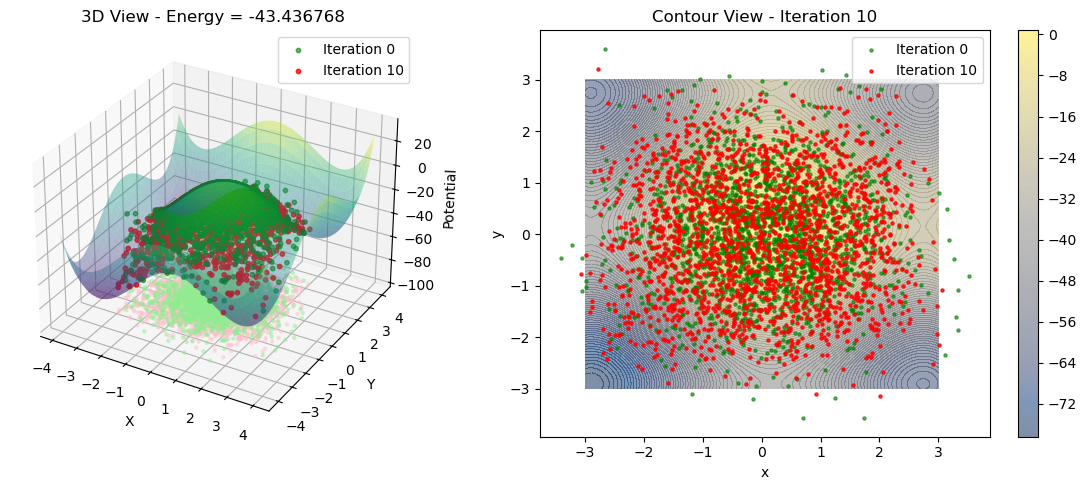

Gradient Flow Progress:   8%|▊         | 20/249 [01:03<10:29,  2.75s/it, Energy=-55.598934, Linear=-52.140636, Internal=-3.458296, Interaction=0.000000]

Iter  20: Energy = -55.598934, Grad norm: 1.37e+02


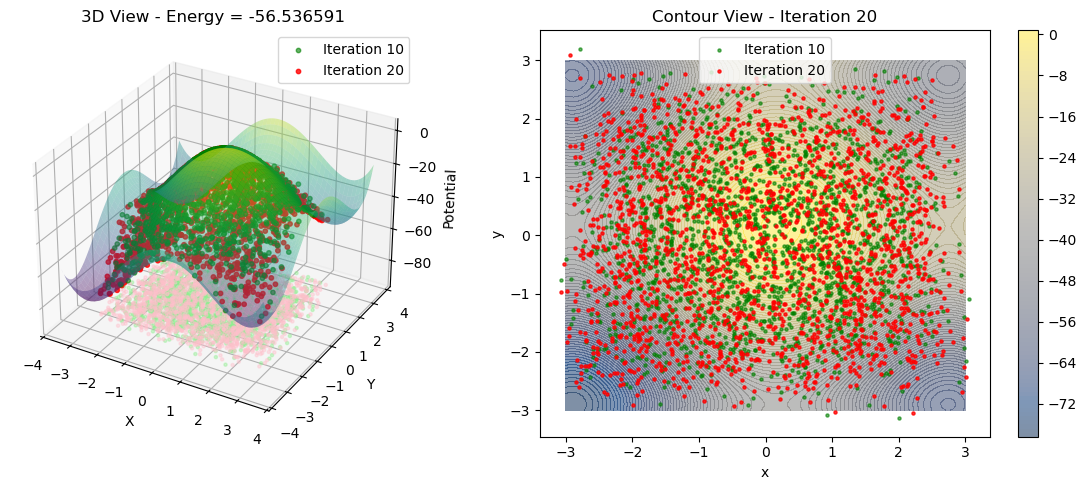

Gradient Flow Progress:  12%|█▏        | 30/249 [01:31<10:02,  2.75s/it, Energy=-70.968513, Linear=-66.670860, Internal=-4.297655, Interaction=0.000000]

Iter  30: Energy = -70.968513, Grad norm: 1.67e+02


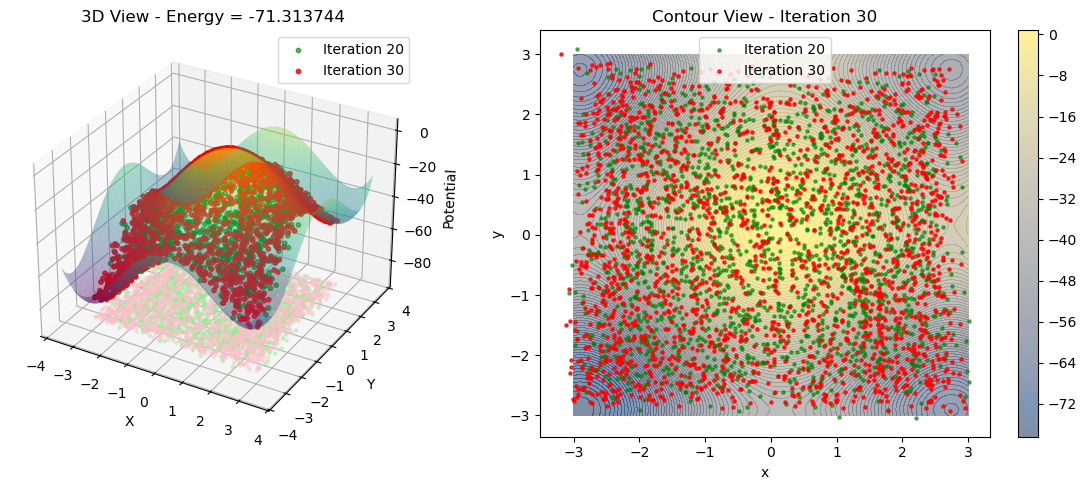

Gradient Flow Progress:  16%|█▌        | 40/249 [02:00<09:35,  2.75s/it, Energy=-84.312241, Linear=-79.762604, Internal=-4.549633, Interaction=0.000000]

Iter  40: Energy = -84.312241, Grad norm: 1.47e+02


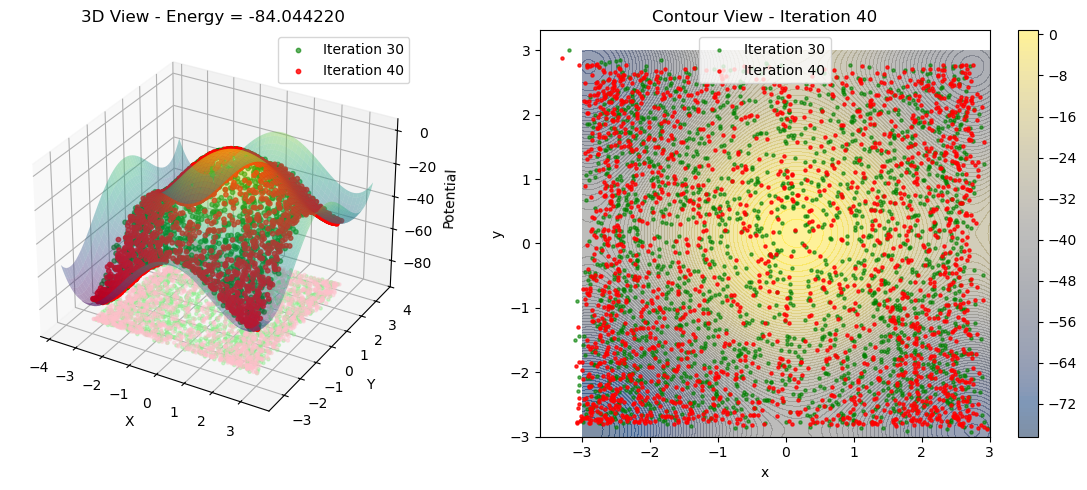

Gradient Flow Progress:  20%|██        | 50/249 [02:29<09:07,  2.75s/it, Energy=-92.933235, Linear=-88.550591, Internal=-4.382643, Interaction=0.000000]

Iter  50: Energy = -92.933235, Grad norm: 1.24e+02


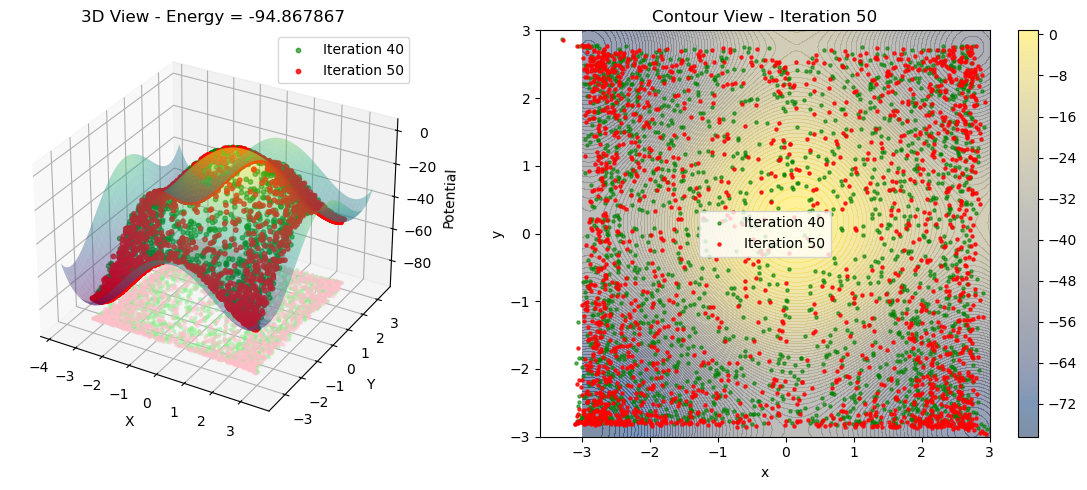

Gradient Flow Progress:  24%|██▍       | 60/249 [02:57<08:37,  2.74s/it, Energy=-103.427139, Linear=-99.529846, Internal=-3.897293, Interaction=0.000000]

Iter  60: Energy = -103.427139, Grad norm: 1.04e+02


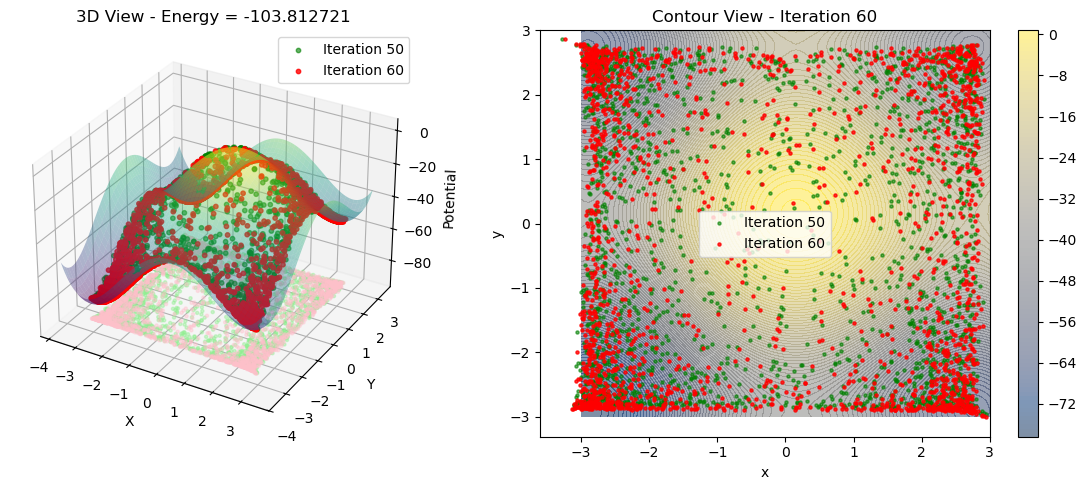

Gradient Flow Progress:  28%|██▊       | 70/249 [03:26<08:11,  2.75s/it, Energy=-109.481903, Linear=-106.011940, Internal=-3.469962, Interaction=0.000000]

Iter  70: Energy = -109.481903, Grad norm: 8.21e+01


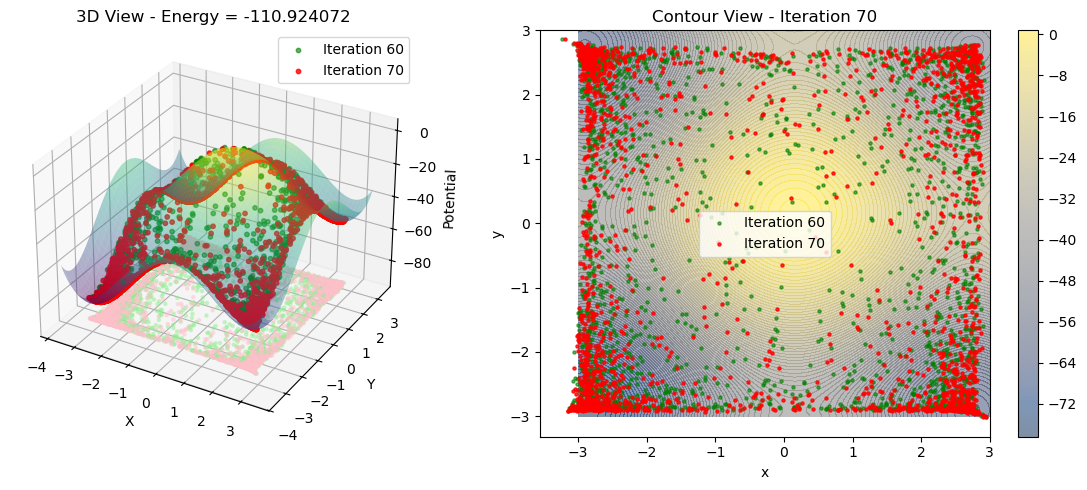

Gradient Flow Progress:  30%|██▉       | 74/249 [03:38<08:37,  2.96s/it, Energy=-110.979095, Linear=-107.611664, Internal=-3.367433, Interaction=0.000000]


KeyboardInterrupt: 

In [17]:

results = run_gradient_flow(
    gradient_flow_model, z_samples, G_mat_flow,
    potential,device_idx=device
    ,solver=solver,
    h=h, max_iterations=max_iterations, tolerance=tolerance,
    progress_every=10
)

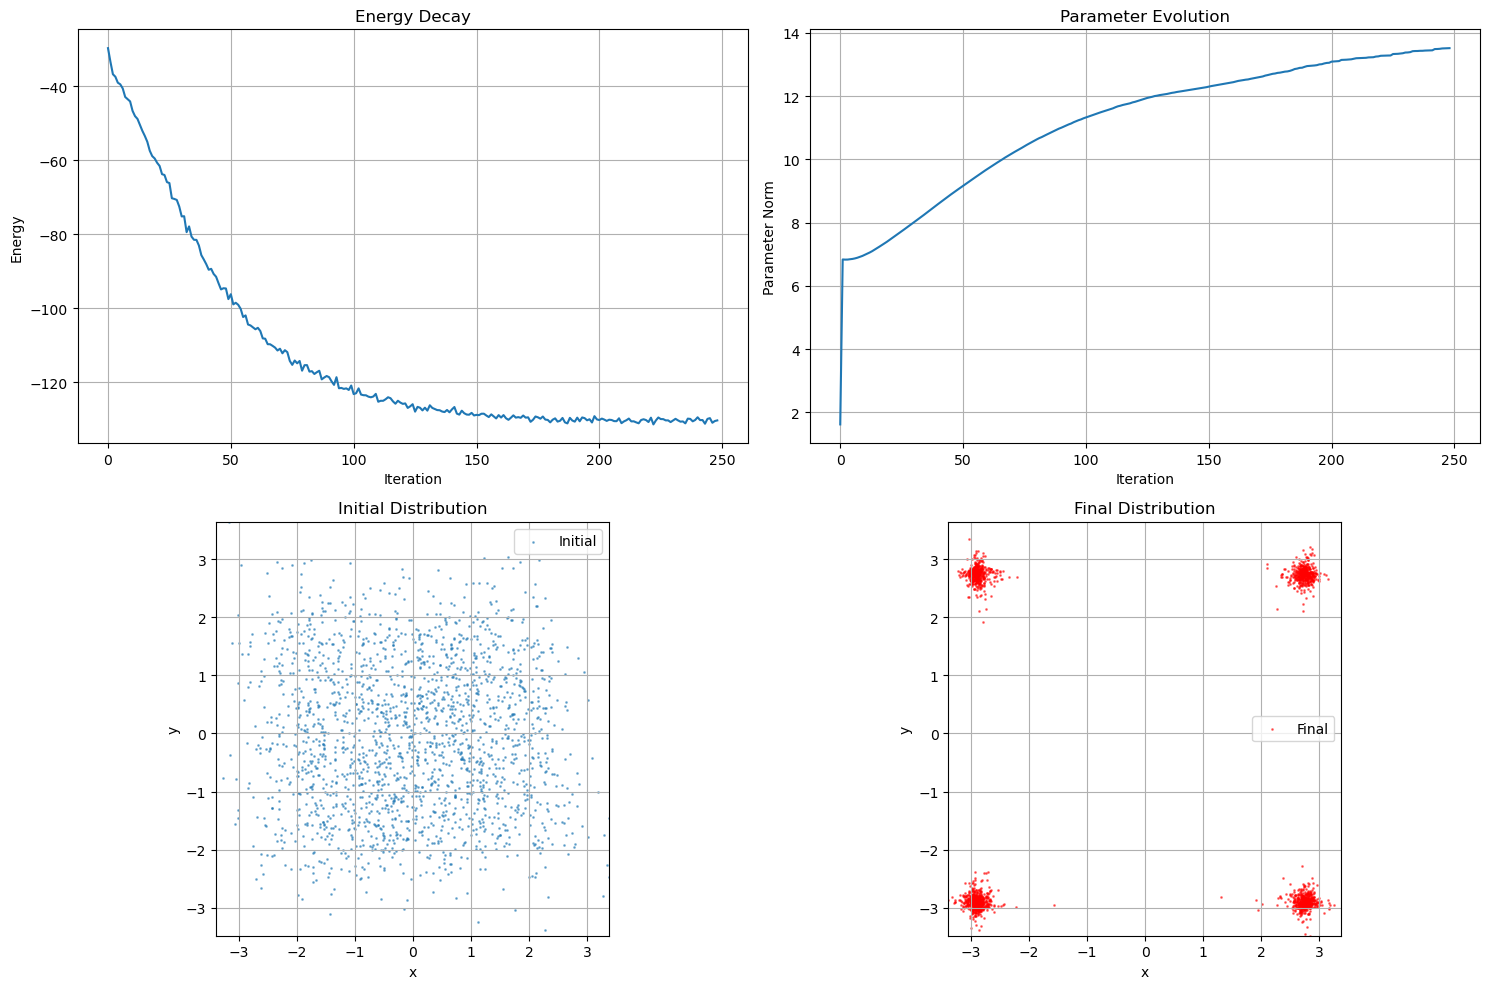

In [ ]:
# Visualize results
visualize_gradient_flow_results(results)

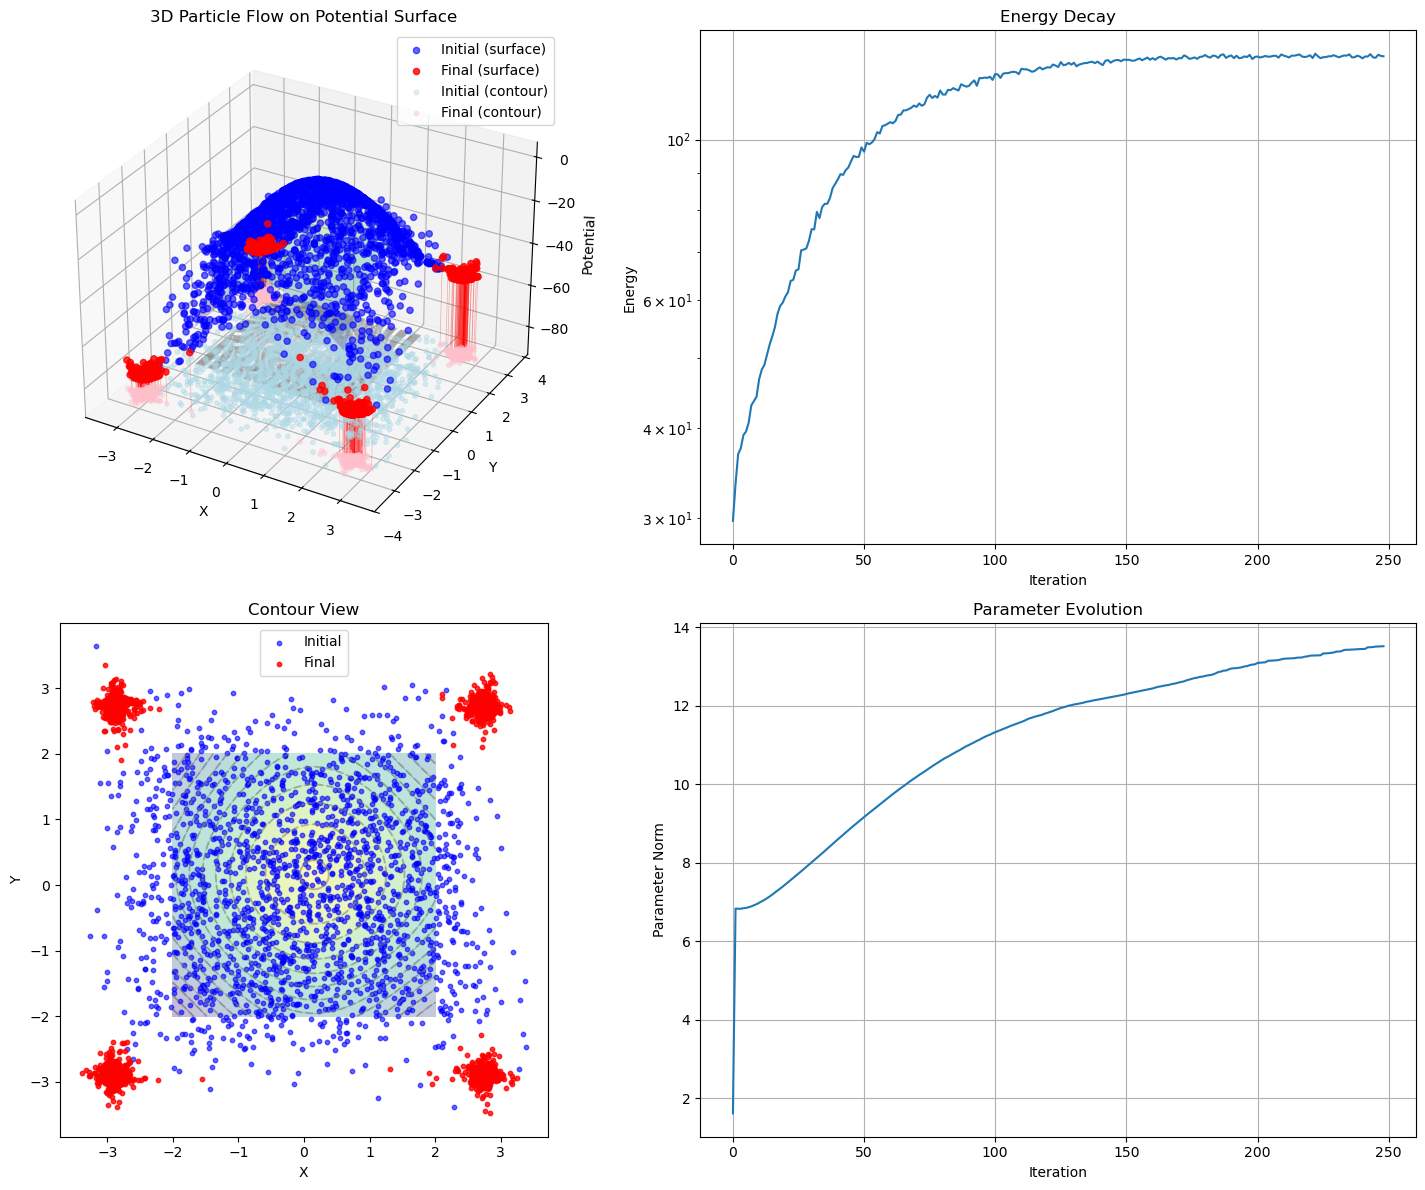

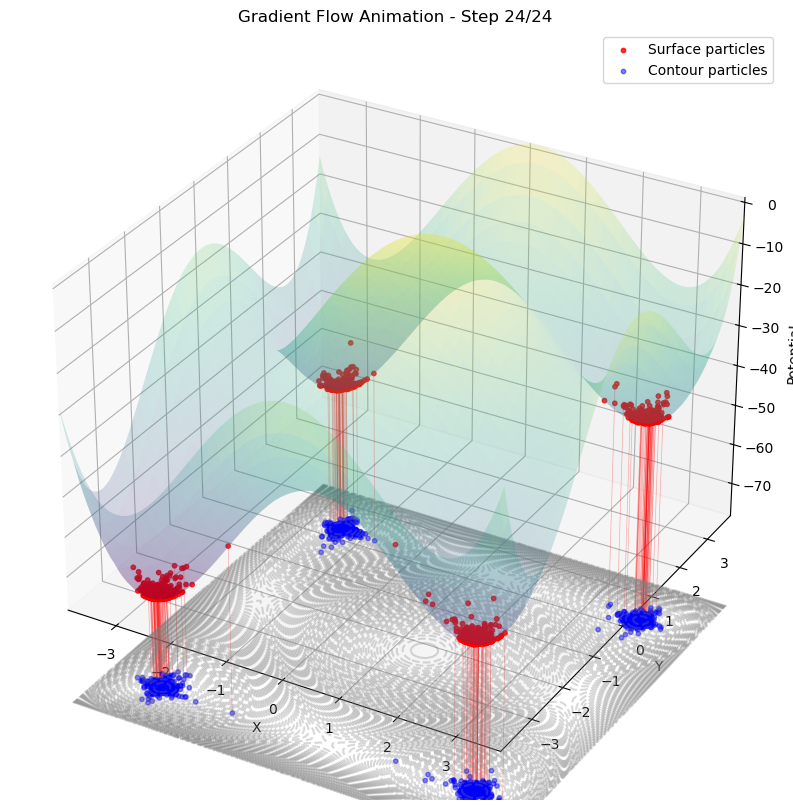

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

def visualize_gradient_flow_3d(results: dict, potential: Potential, figsize: tuple = (15, 12), x_range=None, y_range=None):
    """
    Enhanced 3D visualization showing particles on potential surface and contour plane
    
    Args:
        results: Results dictionary from run_gradient_flow
        potential_func: Function that takes (x, y) and returns potential value
        figsize: Figure size for plots
    """
    fig = plt.figure(figsize=figsize)
    
    # Create 3D subplot
    ax_3d = fig.add_subplot(221, projection='3d')
    
    # Get particle data
    initial_samples = results['sample_history'][0]
    final_samples = results['sample_history'][-1]
    
    # Create potential surface mesh
    if x_range is None:
        x_range = jnp.linspace(initial_samples[:,0].min() - 0.5, initial_samples[:,0].max() + 0.5, 100)
    if y_range is None:
        y_range = jnp.linspace(initial_samples[:,1].min() - 0.5, initial_samples[:,1].max() + 0.5, 100)
    # x_range = jnp.linspace(initial_samples[:,0].min() , initial_samples[:,0].max(), 100)
    # y_range = jnp.linspace(initial_samples[:,1].min() , initial_samples[:,1].max(), 100)
    X, Y = jnp.meshgrid(x_range, y_range)
    Z = jnp.zeros_like(X)

    # Evaluate potential on mesh
    Z = potential.linear.potential_fn(jnp.stack([X.ravel(), Y.ravel()], axis=-1),**potential.linear.potential_kwargs).reshape(X.shape)

    base_z = Z.min() - 0.3 * (Z.max() - Z.min())
    # base_x = X.min() - 0.3 * (X.max() - X.min())
    # base_y = Y.min() - 0.3 * (Y.max() - Y.min())

    # Plot potential surface
    ax_3d.plot_surface(X, Y, Z, cmap='viridis', antialiased=True,alpha = 0.3) #
    ax_3d.contour(X, Y, Z,zdir ='z', offset=base_z, levels=150, colors='gray', alpha=0.3)
    # ax_3d.contour(X, Y, Z,zdir ='y',levels = 150,alhpa = 0.3,cmap='viridis')
    # ax_3d.contour(X, Y, Z,zdir ='x',levels = 150,alhpa = 0.3,cmap='viridis')

    # Plot particles at surface level (elevated by potential value)
    # surface_z_initial = np.array([potential_func(x, y) for x, y in initial_samples])
    # surface_z_final = np.array([potential_func(x, y) for x, y in final_samples])
    surface_z_initial = potential.linear.potential_fn(jnp.array(initial_samples),**potential.linear.potential_kwargs)
    surface_z_final = potential.linear.potential_fn(jnp.array(final_samples),**potential.linear.potential_kwargs)

    
    # Surface particles
    ax_3d.scatter(initial_samples[:,0], initial_samples[:,1], surface_z_initial, 
                  c='blue', s=20, alpha=0.6, label='Initial (surface)')
    ax_3d.scatter(final_samples[:,0], final_samples[:,1], surface_z_final, 
                  c='red', s=20, alpha=0.8, label='Final (surface)')
    
    # Contour particles (at base level)
    base_z = Z.min() - 0.5 * (Z.max() - Z.min())
    ax_3d.scatter(initial_samples[:,0], initial_samples[:,1], base_z, 
                  c='lightblue', s=10, alpha=0.4, label='Initial (contour)')
    ax_3d.scatter(final_samples[:,0], final_samples[:,1], base_z, 
                  c='pink', s=10, alpha=0.4, label='Final (contour)')
    
    # Add drop lines for final particles
    for i in range(0, len(final_samples), 5):  # Show every 5th particle to avoid clutter
        x, y = final_samples[i]
        z_surf = surface_z_final[i]
        ax_3d.plot([x, x], [y, y], [base_z, z_surf], 'r-', alpha=0.3, linewidth=0.5)
    
    ax_3d.set_xlabel('X')
    ax_3d.set_ylabel('Y')
    ax_3d.set_zlabel('Potential')
    ax_3d.set_title('3D Particle Flow on Potential Surface')
    ax_3d.legend()
    
    # Energy decay plot
    ax_energy = fig.add_subplot(222)
    ax_energy.plot(abs(jnp.array(results['energy_history'])))
    ax_energy.set_xlabel('Iteration')
    ax_energy.set_ylabel('Energy')
    ax_energy.set_title('Energy Decay')
    ax_energy.grid(True)
    ax_energy.set_yscale('log')
    
    # 2D contour plot with particles
    ax_contour = fig.add_subplot(223)
    contour = ax_contour.contour(X, Y, Z, levels=15, colors='gray', alpha=0.5)
    ax_contour.contourf(X, Y, Z, levels=15, alpha=0.3, cmap='viridis')
    ax_contour.scatter(initial_samples[:,0], initial_samples[:,1], 
                      c='blue', s=10, alpha=0.6, label='Initial')
    ax_contour.scatter(final_samples[:,0], final_samples[:,1], 
                      c='red', s=10, alpha=0.8, label='Final')
    ax_contour.set_xlabel('X')
    ax_contour.set_ylabel('Y')
    ax_contour.set_title('Contour View')
    ax_contour.legend()
    ax_contour.set_aspect('equal')
    
    # Parameter evolution
    ax_params = fig.add_subplot(224)
    ax_params.plot(results['param_norms'])
    ax_params.set_xlabel('Iteration')
    ax_params.set_ylabel('Parameter Norm')
    ax_params.set_title('Parameter Evolution')
    ax_params.grid(True)
    
    plt.tight_layout()
    plt.show()


def animate_gradient_flow_3d(results: dict, potential, save_path=None):
    """
    Animate the 3D particle flow over time
    
    Args:
        results: Results dictionary from run_gradient_flow
        potential_func: Function that takes (x, y) and returns potential value
        save_path: Optional path to save animation as gif
    """
    from matplotlib.animation import FuncAnimation
    
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    # Create surface mesh
    sample_history = results['sample_history']
    all_samples = np.vstack(sample_history)
    
    x_range = np.linspace(all_samples[:,0].min() - 0.5, all_samples[:,0].max() + 0.5, 100)
    y_range = np.linspace(all_samples[:,1].min() - 0.5, all_samples[:,1].max() + 0.5, 100)
    X, Y = np.meshgrid(x_range, y_range)
    Z = potential.linear.potential_fn(jnp.stack([X.ravel(), Y.ravel()], axis=-1),**potential.linear.potential_kwargs).reshape(X.shape)

    # Plot static surface
    ax.plot_surface(X, Y, Z, alpha=0.4, cmap='viridis', linewidth=0)
    
    # Base level for contour particles
    base_z = Z.min() - 0.3 * (Z.max() - Z.min())
    
    def animate(frame):
        ax.clear()
        
        
        
        # Get current samples
        current_samples = sample_history[frame]
        surface_z = potential.linear.potential_fn(jnp.array(current_samples),**potential.linear.potential_kwargs)

        x_min = current_samples[:,0].min() - 0.5
        x_max = current_samples[:,0].max() + 0.5
        y_min = current_samples[:,1].min() - 0.5
        y_max = current_samples[:,1].max() + 0.5

        X, Y = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
        Z = potential.linear.potential_fn(jnp.stack([X.ravel(), Y.ravel()], axis=-1),**potential.linear.potential_kwargs).reshape(X.shape)

        base_z = Z.min() - 0.3 * (Z.max() - Z.min())

        # Redraw surface
        ax.plot_surface(X, Y, Z, alpha=0.2, cmap='viridis', linewidth=0)
        ax.contour(X, Y, Z,zdir ='z', offset=base_z, levels=150, colors='gray', alpha=0.3)
        ax.contour(X, Y, Z,zdir ='y', offset=base_z, levels=150, alpha=0.3, cmap='viridis')

        # Plot surface particles
        ax.scatter(current_samples[:,0], current_samples[:,1], surface_z, 
                  c='red', s=10, alpha=0.8, label='Surface particles')
        
        # Plot contour particles
        ax.scatter(current_samples[:,0], current_samples[:,1], base_z, 
                  c='blue', s=10, alpha=0.5, label='Contour particles')
        
        # Add some drop lines
        for i in range(0, len(current_samples), 10):
            x, y = current_samples[i]
            z_surf = surface_z[i]
            ax.plot([x, x], [y, y], [base_z, z_surf], 'r-', alpha=0.3, linewidth=0.5)
        
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Potential')
        ax.set_title(f'Gradient Flow Animation - Step {frame}/{len(sample_history)-1}')
        ax.legend()
        
        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)
        # Keep consistent view
        # ax.set_xlim(x_range[0], x_range[-1])
        # ax.set_ylim(y_range[0], y_range[-1])
        ax.set_zlim(Z.min(), Z.max())
    
    anim = FuncAnimation(fig, animate, frames=len(sample_history), interval=400, blit=False)
    
    if save_path:
        anim.save(save_path, writer='pillow', fps=3)
    
    plt.show()
    return anim


# Example usage:
visualize_gradient_flow_3d(results, potential,x_range=jnp.linspace(-2,2,100),y_range=jnp.linspace(-2,2,100))  # Simple quadratic potential
anim = animate_gradient_flow_3d(results, potential, 'flow_animation.gif')

In [ ]:
final_node = results['final_node']
G_mat = G_matrix(final_node)
h = 1e-4
max_iterations = 150

In [ ]:

results_ = run_gradient_flow(
    final_node, z_samples, G_mat,
    potential,device_idx=device
    ,solver=solver,
    h=h, max_iterations=max_iterations, tolerance=tolerance,
    progress_every=5
)

Selected device: cuda:0


Gradient Flow Progress:   1%|▏         | 2/149 [00:19<23:17,  9.50s/it, Energy=-129.891312, Linear=-130.007996, Internal=0.116690, Interaction=0.000000] 


KeyboardInterrupt: 

In [ ]:
# Example usage:
visualize_gradient_flow_3d(results_, potential,x_range=jnp.linspace(-4,4,100),y_range=jnp.linspace(-4,4,100))  # Simple quadratic potential
anim = animate_gradient_flow_3d(results_, potential, 'flow_animation2.gif')